<a href="https://colab.research.google.com/github/s-shahd-h/Brain-tumor-MRI-classification/blob/main/Copy_of_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras,os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input  # Import preprocess_input


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tombackert/brain-tumor-mri-data")

print("Path to dataset files:", path)

100%|██████████| 151M/151M [00:02<00:00, 54.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tombackert/brain-tumor-mri-data/versions/1


In [ ]:
print("Contents of the base path:")
print(os.listdir(path))

Contents of the base path:
['brain-tumor-mri-dataset']


In [ ]:
dataset_path = os.path.join(path, "brain-tumor-mri-dataset")

# Check the contents of the dataset folder
print("Contents of 'Brain Tumor Dataset':")
classes =os.listdir(dataset_path)
print(classes)

Contents of 'Brain Tumor Dataset':
['meningioma', 'glioma', 'notumor', 'pituitary']


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Directories for train and test splits
train_dir = "dataset/train"
test_dir = "dataset/test"

# Create train and test directories with subfolders for each class
for directory in [train_dir, test_dir]:
    for class_name in classes:
        os.makedirs(os.path.join(directory, class_name), exist_ok=True)

# Split the data for each class
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)

    # Split images into train and test
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    # Move images to train directory
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name))

    # Move images to test directory
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name))

print("Dataset split into train and test successfully!")


Dataset split into train and test successfully!


In [ ]:
import os

def count_images_in_directory(directory_path):
    total_images = 0
    class_counts = {}

    for class_name in os.listdir(directory_path):
        class_path = os.path.join(directory_path, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
            total_images += num_images

    return total_images, class_counts

# Paths to train and test directories
train_dir = "dataset/train"
test_dir = "dataset/test"

# Count images
train_total, train_counts = count_images_in_directory(train_dir)
test_total, test_counts = count_images_in_directory(test_dir)

# Display results
print("Training Set:")
print(f"  Total images: {train_total}")
for label, count in train_counts.items():
    print(f"  {label}: {count} images")

print("\nTest Set:")
print(f"  Total images: {test_total}")
for label, count in test_counts.items():
    print(f"  {label}: {count} images")


Training Set:
  Total images: 5721
  meningioma: 1420 images
  glioma: 1296 images
  notumor: 1600 images
  pituitary: 1405 images

Test Set:
  Total images: 1432
  meningioma: 355 images
  glioma: 325 images
  notumor: 400 images
  pituitary: 352 images


In [ ]:
# Parameters
img_size = 224
batch_size = 32
epochs = 70
num_classes = 4  # Number of classes in the dataset
target_size = (img_size, img_size)

Found 5721 images belonging to 4 classes.


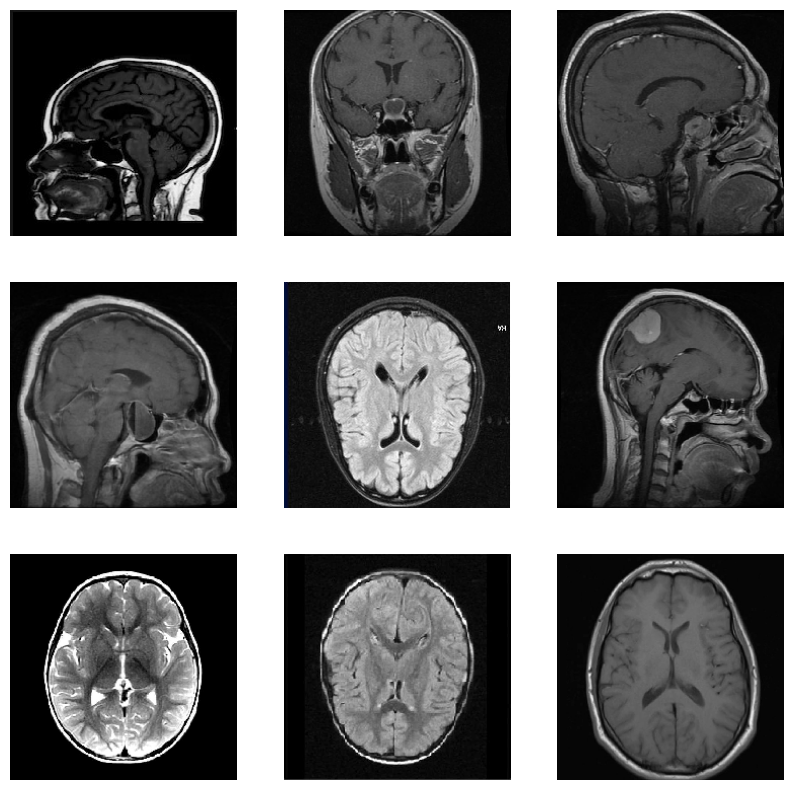

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


original_datagen = ImageDataGenerator(rescale=1.0 / 255.0)


original_generator = original_datagen.flow_from_directory(
    "dataset/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)


for images, labels in original_generator:
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    break



In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG19-specific preprocessing
    validation_split=0.2,
   # Fill in missing pixels using the nearest neighbor
)



test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
 )

In [ ]:
# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',  # For multi-class classification
    shuffle=True
)

# validation data generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical',  # For multi-class classification
    shuffle=True
)


# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4577 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.
Found 1432 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D
def create_model():
    # Load VGG19 model with pretrained weights, excluding the top (fully connected) layers
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


    for layer in resnet_base.layers[:15]:
        layer.trainable = False

    # Build the model
    model = Sequential([
        resnet_base,  # Add the base model
        GlobalAveragePooling2D(),  # Replace Flatten with GAP for efficiency
        Dense(256, activation='relu', kernel_regularizer=l2(0.02)),  # Regularization
        BatchNormalization(),
        Dropout(0.6),  # Prevent overfitting
        Dense(128, activation='relu',kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(4, activation='softmax')  # For multi-class classification

    ])


    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])
    return model

model = create_model()




94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))



In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(
 monitor='val_loss',
 factor=0.5,
 patience=3,
 min_lr=1e-6,
 verbose=1
)

# Callbacks
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [ ]:
# Train the model with additional regularization
History = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=[early_stopping_monitor, lr_scheduler]
)

Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 134s 515ms/step - accuracy: 0.6034 - loss: 11.7784 - val_accuracy: 0.8820 - val_loss: 10.4104 - learning_rate: 1.0000e-04
Epoch 2/70
144/144 ━━━━━━━━━━━━━━━━━━━━ 42s 288ms/step - accuracy: 0.9008 - loss: 10.1538 - val_accuracy: 0.9493 - val_loss: 9.2739 - learning_rate: 1.0000e-04
Epoch 3/70
144/144 ━━━━━━━━━━━━━━━━━━━━ 81s 284ms/step - accuracy: 0.9487 - loss: 9.0314 - val_accuracy: 0.9598 - val_loss: 8.2154 - learning_rate: 1.0000e-04
Epoch 4/70
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - accuracy: 0.9839 - loss: 7.8923 - val_accuracy: 0.9729 - val_loss: 7.1209 - learning_rate: 1.0000e-04
Epoch 5/70
144/144 ━━━━━━━━━━━━━━━━━━━━ 82s 280ms/step - accuracy: 0.9870 - loss: 6.8323 - val_accuracy: 0.9598 - val_loss: 6.1679 - learning_rate: 1.0000e-04
Epoch 6/70
144/144 ━━━━━━━━━━━━━━━━━━━━ 42s 288ms/step - accuracy: 0.9922 - loss: 5.8171 - val_accuracy: 0.9755 - val_loss: 5.1823 - learning_rate: 1.0000e-04
Epoch 7/70
144/144 ━━━━━━━━━━━━━━━━━━━━ 43s 295ms/ste

In [ ]:
# 4. Evaluate the Model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Accuracy: {test_acc:.2f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9907 - loss: 0.0999
Test Accuracy: 0.99


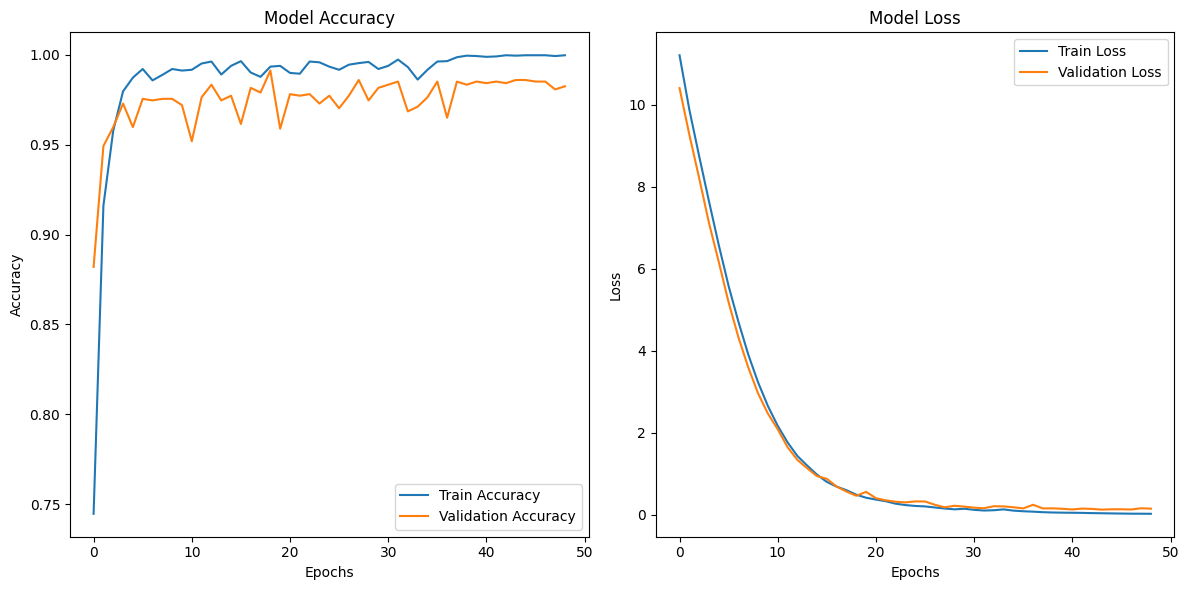

In [ ]:
import matplotlib.pyplot as plt

# Extract the training history
history = History.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
final_train_acc = History.history['accuracy'][-1]
final_val_acc = History.history['val_accuracy'][-1]
final_train_loss = History.history['loss'][-1]
final_val_loss = History.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.9998
Final Validation Accuracy: 0.9825
Final Training Loss: 0.0283
Final Validation Loss: 0.1536


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize


# 2. Get Predicted Probabilities for Test Data
y_pred_prob = model.predict(test_generator, steps=len(test_generator)) # Use len(test_generator) to predict on all batches

# ... (rest of the code remains the same)

# 3. Get True Labels
y_true = test_generator.classes  # True labels from test generator

# 4. Binarize True Labels (for multi-class classification)
num_classes = len(test_generator.class_indices)  # Number of classes
y_true_binarized = label_binarize(y_true, classes=range(num_classes))

# 5. Plot ROC Curve
plt.figure(figsize=(10, 8))

# Loop through each class and compute ROC
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    auc = roc_auc_score(y_true_binarized[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')

# Add diagonal line (random guess reference)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Finalize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step


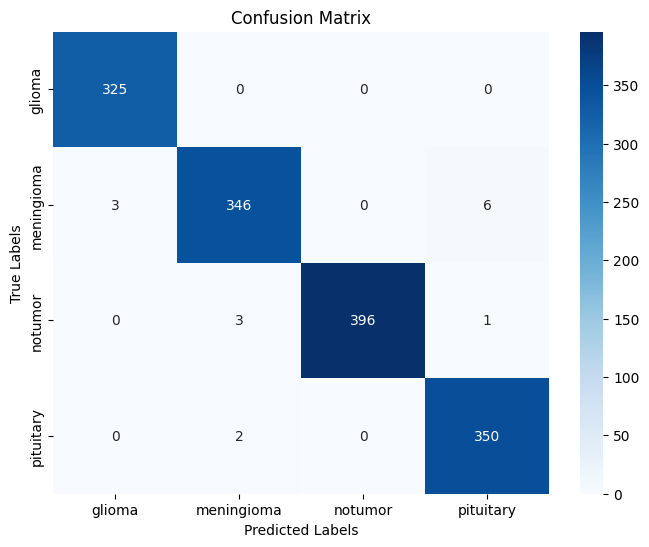

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 5. Confusion Matrix
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()




In [ ]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

In [ ]:
train_files = train_generator.filenames
test_files = test_generator.filenames

# Check for common filenames
overlap = set(train_files).intersection(set(test_files))
print(f"Number of overlapping files: {len(overlap)}")
if overlap:
    print("Data leakage detected!")
else:
    print("No data leakage.")
